In [1]:
# Import pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from pygeocoder import Geocoder
from geopy.geocoders import Nominatim
from geopy.distance import vincenty



In [43]:
# Pull the comprehensive police reported incidents file, dated from 2007 to 2013.
incidents_180 = pd.read_csv('arrests_180_days.csv')
incidents_180.dropna(inplace=True)
incidents_180.head(5)

,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
0,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),2/13/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
1,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),1/2/17 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
2,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),12/9/16 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
3,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),12/14/16 17:00,0 BLOCK UNKNOWN,92020.0,EL CAJON
4,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),3/28/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO


In [45]:
# Filter dataframe down to info on just DUI incidents
dui_incidents_180 = incidents_180[incidents_180['Charge_Description_Orig'].str.contains("DUI")]
dui_incidents_180.head(5)


,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
15932,EL CAJON,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,5/12/17 1:39,700 S BLOCK MAGNOLIA AVENUE,92020.0,EL CAJON
15933,CHULA VISTA,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,3/10/17 0:09,EVANS AVENUE / E L STREET,91911.0,CHULA VISTA
15935,SHERIFF,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,2/3/17 22:25,400 BLOCK ALMOND ROAD,92078.0,SAN MARCOS
18415,EL CAJON,DUI .08 ALC:CAUSING BODILY INJ (F),3/24/17 20:20,N 03RD STREET / E MAIN STREET,92020.0,EL CAJON
18416,OCEANSIDE,DUI .08 ALC:CAUSING BODILY INJ (F),12/22/16 21:28,4000 BLOCK VISTA WAY,92056.0,OCEANSIDE


In [46]:
# Read in our zip code csv with population counts
zip_code_df = pd.read_csv('ZipCode_Populations.csv')
zip_code_df.head(5)

,Zip,YEAR,RACE,NUMBER
0,91901,2010,Pacific Islander,43
1,91901,2010,White,13131
2,91901,2010,Black,201
3,91901,2010,Other,9
4,91901,2010,Two or More,375


In [47]:
# Since our population counts are separated by race, lets sum over unique zip codes and 
# accumulate a summed population for each zip.

In [48]:
curr_zip = zip_code_df['Zip'][0]

sums = {}
temp_sum = 0

for i in range(0,len(zip_code_df)):    
    if curr_zip != zip_code_df.iloc[i]['Zip']:
        sums[curr_zip] = temp_sum
        curr_zip = zip_code_df.iloc[i]['Zip']
        temp_sum = zip_code_df.iloc[i]['NUMBER']
    else:
        temp_sum += zip_code_df.iloc[i]['NUMBER']

In [49]:
print(sums)

{91901: 17084, 91902: 17005, 91905: 1669, 91906: 5765, 91910: 76153, 91911: 83249, 91913: 40346, 91914: 15627, 91915: 25126, 91916: 2006, 91917: 2276, 91931: 350, 91932: 26325, 91934: 775, 91935: 8235, 91941: 33302, 91942: 36886, 91945: 25320, 91948: 340, 91950: 55312, 91962: 1698, 91963: 1162, 91977: 59164, 91978: 7956, 91980: 173, 92003: 4354, 92004: 4054, 92007: 10531, 92008: 27568, 92009: 39735, 92010: 14481, 92011: 22393, 92014: 13432, 92019: 42637, 92020: 58407, 92021: 65227, 92024: 52579, 92025: 48275, 92026: 52417, 92027: 53143, 92028: 46449, 92029: 18624, 92036: 3573, 92037: 38652, 92040: 40286, 92054: 37941, 92055: 33412, 92056: 51590, 92057: 54152, 92058: 23406, 92059: 1498, 92060: 778, 92061: 2855, 92064: 47904, 92065: 35365, 92066: 430, 92067: 8689, 92069: 46322, 92070: 697, 92071: 53211, 92075: 11854, 92078: 39983, 92081: 27422, 92082: 17896, 92083: 37082, 92084: 47861, 92086: 1131, 92091: 1621, 92093: 8718, 92096: 622, 92101: 35623, 92102: 42967, 92103: 30680, 92104: 449

In [50]:
# Read in our zip code csv that contains latitude and longitude coordinates. We want to link
# this information to our other zip code data with population counts.

df_zip_coords = pd.read_csv('Zip_Coords.csv')

# Drop unnecessary columns from data, such as Status, City, and State, since we already 
# know our zip code values are San Diego specific.
df_zip_coords.drop(['Idk', 'City', 'State', 'Status'], axis=1, inplace=True)
df_zip_coords.head(10)

,Zip Code,Lat,Lon
0,92101,32.71,-117.16
1,92102,32.72,-117.09
2,92103,32.74,-117.17
3,92104,32.73,-117.12
4,92105,32.73,-117.08
5,92106,32.72,-117.23
6,92107,32.73,-117.24
7,92107,32.73,-117.24
8,92108,32.77,-117.10
9,92109,32.79,-117.23


In [51]:
# Convert our zip codes to string so that we can compare them to the xip codes in our
# population dataframe.
for i in range(0, len(df_zip_coords)):
    df_zip_coords.iloc[i]['Zip Code'] = str(df_zip_coords.iloc[i]['Zip Code'])

df_zip_coords.head(10)

/Users/sarahgeorge/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Zip Code,Lat,Lon
0,92101,32.71,-117.16
1,92102,32.72,-117.09
2,92103,32.74,-117.17
3,92104,32.73,-117.12
4,92105,32.73,-117.08
5,92106,32.72,-117.23
6,92107,32.73,-117.24
7,92107,32.73,-117.24
8,92108,32.77,-117.10
9,92109,32.79,-117.23


In [52]:
# Convert our summed population counts to string
for i in sums:
    sums[i] = str(sums[i])
    
# Create a dataframe from our dictionary of population sums called 'df_zip_pops'.
df_zip_pops = pd.DataFrame.from_dict(sums, orient='index').reset_index()
df_zip_pops.rename(columns = {'index':'Zip Code', 0:'Population'}, inplace=True)

In [53]:
# Let's look at our new dataframe.
print("Length: ", len(df_zip_pops))
df_zip_pops.head(10)


Length:  110


,Zip Code,Population
0,91901,17084
1,91902,17005
2,91905,1669
3,91906,5765
4,91910,76153
5,91911,83249
6,91913,40346
7,91914,15627
8,91915,25126
9,91916,2006


In [57]:
# Merge our first dataset with zipcode coordinates with our second dataset with zipcode
# populations.
merged_zips = pd.merge(df_zip_coords, df_zip_pops, on='Zip Code')
merged_zips = merged_zips.drop_duplicates()
print("Length: ", len(merged_zips))

# Fix any odd indexing that occurs after dropping rows
merged_zips = merged_zips.reset_index(drop=True)

Length:  39


In [58]:
# Let's deal with population.
# Create a column in our dataframe with a 'distributed population', that divides our 
# summed count by a set radius value, r^2. 
# *Note* this is assuming evenly distributed population in a zip code area


# Initialize a series called 'distributed_pop'
distributed_pop = pd.Series()

# Add to dataframe
merged_zips['distributed_pop'] = distributed_pop
merged_zips.head(5)

# Set radius value
radius = 2

for i in range(0, len(merged_zips)):
    merged_zips.set_value(i, 'distributed_pop', 
                          str(((int(merged_zips.iloc[i]['Population']))/(radius*radius))))

# Only need the coordinate values and distributed population in final dataframe for analysis
merged_zips = merged_zips[['Lat','Lon','distributed_pop']]
merged_zips.head(5)

,Lat,Lon,distributed_pop
0,32.71,-117.16,8905.75
1,32.72,-117.09,10741.75
2,32.74,-117.17,7670.00
3,32.73,-117.12,11236.75
4,32.73,-117.08,17567.50


# Now lets put all of our data into a matrix of lists.
We are going to make a matrix based off of coordinates ranges in our map. Each square in the map with contains a list of 4 items: 

crashes -  number of DUI related crashes in the area

arrests - number of DUI related arrests in the area

licenses - number of alcohol licenses in the area

population - population size in the area

In [59]:
# Initialize boundary values for our grid that will model a slice of San Diego.

min_lat = 32.54
max_lat = 33.05
min_lon = -117.25
max_lon = -116.95

#number of matrix columns and rows
matrix_dim = 10

#make matrix
matrix = [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]

#width of a cell
cell_width = abs((max_lat - min_lat)/matrix_dim)

#height of a cell
cell_height = (max_lon - min_lon)/matrix_dim

print("Matrix will be of dimension " + str(matrix_dim) + "x" + str(matrix_dim) + '\n')
print("Cell width: " + str(cell_width) + " latitude points")
print("Cell height: " + str(cell_height) + " longitude points" + '\n')

print(matrix)

Matrix will be of dimension 10x10

Cell width: 0.0509999999999998 latitude points
Cell height: 0.029999999999999714 longitude points

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [60]:
# Read in our geocoded data for crashes.
crash_data = pd.read_csv('crash_coordinates.csv')
crash_data.head(5)

,0,"(30.0206764, -90.10265509999999)"
0,1,"(32.9178621, -117.1426708)"
1,2,"(41.4580185, -96.4925694)"
2,3,"(38.9062481, -90.13781209999999)"
3,4,"(36.077923, -102.519732)"
4,5,"(32.6972057, -117.032704)"


In [61]:
# ARREST ARRAY
arrest_data = pd.read_csv('dui_incidents_180.csv')
arrest_data = arrest_data['coordinates']

arrest_coords_arr = np.zeros(len(arrest_data), dtype=('2float'))
coord = []
# Organize arrest coordinates 
for i in range(0,len(arrest_data)-1):
    coord = arrest_data.iloc[i]
    opening_paren_index = coord.find("(")
    comma_index = coord.find(",")
    closing_parn_index = coord.find(")")
    arrest_lat = float(coord[opening_paren_index+1:comma_index])
    arrest_lng = float(coord[comma_index+2:closing_parn_index])
    arrest_coords_arr[i] = ((arrest_lat,arrest_lng))

In [62]:
# CRASH ARRAY
crash_coords_df = pd.read_csv('crash_coordinates.csv')

crash_coords_arr = np.zeros(len(df_zip_coords), dtype=('2float'))
for i in range(0,len(crash_coords_arr)-1):
    coord = crash_coords_df.iloc[i]
    opening_paren_index = coord[1].find("(")
    comma_index = coord[1].find(",")
    closing_parn_index = coord[1].find(")")
    crash_lat = float(coord[1][opening_paren_index+1:comma_index])
    crash_lng = float(coord[1][comma_index+2:closing_parn_index])
    crash_coords_arr[i] = ((crash_lat,crash_lng))



In [63]:
# ALCOHOL PERMIT ARRAY
alc_permits = pd.read_csv('abs-licenses-casnd.csv')
crash_coordinates_s = pd.read_csv("crash_coordinates.csv")
crash_coordinates_s.head(5)

# Reduce to pertinent data columns
alc_permits = alc_permits[['last_date', 'status', 'issuedate', 'exprdate', 'lon', 'lat', 'business']]
# Filter out data that may be outside the San Diego area.
# Limit range so that any outliers or typos in data are eliminated

alc_permits = alc_permits.drop(alc_permits[alc_permits['lon'] < -120].index)
alc_permits.dropna(inplace = True)
#Alcohol Permits SCATTER PLOTTING

permit_coords = np.zeros(len(alc_permits), dtype=('2float'))

for i in range(0, len(alc_permits)):
    alc_lat = float(alc_permits['lat'].iloc[i])
    alc_lng = float(alc_permits['lon'].iloc[i])
    permit_coords[i] = (alc_lat, alc_lng)

In [64]:
# Input data into matrix lists

for i in range(matrix_dim):
    for j in range(matrix_dim):
        # Initialize array to count instances that a coordinate meets boundary conditions
        in_list=[]
        crash_array=[]
        arrest_array=[]
        permit_array=[]
        pop_array=[]
        #print(float(merged_zips.loc[0][1]))
        for k in range(len(crash_coords_arr)):
            crash_bool = ((crash_coords_arr[k][0] >= min_lat + cell_width*i) 
                             and (crash_coords_arr[k][0] <= min_lat + cell_width*(i+1))
                             and (crash_coords_arr[k][1] >= min_lon + cell_height*j) 
                             and (crash_coords_arr[k][1] <= min_lon + cell_height*(j+1)))
            if crash_bool == True:
                crash_array.append(1)
        for k in range(len(arrest_coords_arr)):
            arrest_bool = ((arrest_coords_arr[k][0] >= min_lat + cell_width*i) 
                             and (arrest_coords_arr[k][0] <= min_lat + cell_width*(i+1))
                             and (arrest_coords_arr[k][1] >= min_lon + cell_height*j) 
                             and (arrest_coords_arr[k][1] <= min_lon + cell_height*(j+1)))
            if arrest_bool == True:
                arrest_array.append(1)
        for k in range(len(permit_coords)):
            permit_bool = ((permit_coords[k][0] >= min_lat + cell_width*i) 
                             and (permit_coords[k][0] <= min_lat + cell_width*(i+1))
                             and (permit_coords[k][1] >= min_lon + cell_height*j) 
                             and (permit_coords[k][1] <= min_lon + cell_height*(j+1)))
            if permit_bool == True:
                permit_array.append(1)
        for k in range(len(merged_zips)):
            pop_bool = ((float(merged_zips.loc[k][0]) >= min_lat + cell_width*i) 
                             and (float(merged_zips.loc[k][0]) <= min_lat + cell_width*(i+1))
                             and (float(merged_zips.loc[k][1]) >= min_lon + cell_height*j) 
                             and (float(merged_zips.loc[k][1]) <= min_lon + cell_height*(j+1)))
            if pop_bool == True:
                pop_array.append(merged_zips.loc[k][2])
        ###############################
        # How we organized our 4 data points:
        # list[0] = # of crashes
        # list[1] = # of arrests
        # list[2] = # of permits
        # list[3] = # of people
        ###########################
        in_list.append(len(crash_array))
        in_list.append(len(arrest_array))
        in_list.append(len(permit_array))
        in_list.append(sum(pop_array))
        matrix[j][i] = in_list
print(matrix)

### NOTE: Sum for population count

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 4, 85, 12194.0], [6, 38, 58, 11450.5], [1, 24, 60, 0], [0, 2, 11, 0], [1, 3, 23, 0], [0, 0, 120, 0], [0, 0, 8, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 46, 858.75], [2, 10, 139, 0], [3, 32, 36, 12654.25], [2, 8, 56, 10845.5], [0, 0, 16, 1063.25], [0, 1, 4, 12429.0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 41, 283.75], [0, 1, 183, 19064.5], [5, 5, 86, 5963.0], [0, 13, 55, 24621.75], [0, 0, 13, 0], [0, 0, 16, 0], [1, 1, 2, 12429.0], [0, 0, 0, 0]], [[0, 0, 8, 0], [0, 0, 1, 0], [0, 0, 0, 4544.0], [1, 8, 153, 8944.5], [6, 17, 152, 0], [1, 12, 130, 18553.25], [0, 0, 11, 18259.75], [3, 3, 21, 0], [0, 1, 2, 0], [0, 1, 0, 0]], [[0, 0, 12, 0], [0, 0, 5, 0], [0, 2, 23, 15689.75], [0, 3, 72, 11236.75], [1, 21, 129, 12407.5], [0, 2, 30, 6585.75], [0, 0, 11, 18259.25], [1, 4, 36, 0], [0, 4, 19, 12802.0], [0, 0, 18, 9818.0]], [[0, 0, 13, 0], [0, 0, 82, 0], [0, 0, 112, 0], [5, 6, 29, 28309.25], [3, 18, 89, 4547.75], [1, 2, 8, 758

# Visualization and Analysis

# 1. Heatmapping

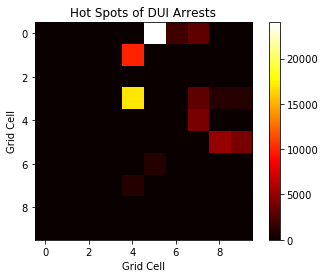

In [65]:
# HEATMAPPING ARRESTS
arrest_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        arrest_matrix[i][j] = in_list[1]/population

plt.imshow(arrest_matrix, cmap='hot', interpolation='nearest')
p = plt.colorbar()
plt.title('Hot Spots of DUI Arrests')
plt.xlabel('Grid Cell')
plt.ylabel('Grid Cell')
plt.show()

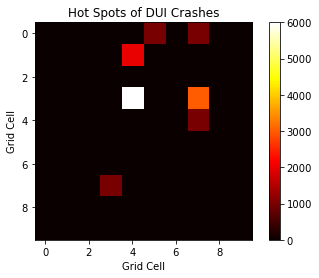

In [66]:
# HEATMAPPING Crashes
crash_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        crash_matrix[i][j] = in_list[0]/population

plt.imshow(crash_matrix, cmap='hot', interpolation='nearest')
p = plt.colorbar()
plt.title('Hot Spots of DUI Crashes')
plt.xlabel('Grid Cell')
plt.ylabel('Grid Cell')
plt.show()

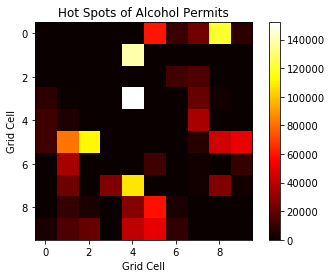

In [67]:
# HEATMAPPING Permits
permit_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        permit_matrix[i][j] = in_list[2]/population

plt.imshow(permit_matrix, cmap='hot', interpolation='nearest')
plt.title('Hot Spots of Alcohol Permits')
plt.xlabel('Grid Cell')
plt.ylabel('Grid Cell')
p = plt.colorbar()
plt.show()

# 2. Scatterplotting

Ratio of Crashes per Arrest:  0.130850866568


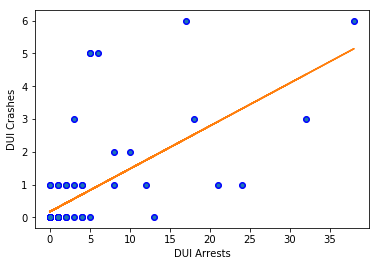

In [75]:
# ARREST v. CRASH SCATTERPLOT
import matplotlib.patches as mpatches

arrest_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        arrest_matrix_scatter[i][j] = in_list[1]

crash_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        crash_matrix_scatter[i][j] = in_list[0]


AF = np.array(arrest_matrix_scatter).flatten()
CF = np.array(crash_matrix_scatter).flatten()

plt.scatter(AF[:],CF[:], c='blue')
# Set our axis data
x = AF
y = CF

# Fit to a line with polyfit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
print("Ratio of Crashes per Arrest: ", m)
plt.xlabel('DUI Arrests')
plt.ylabel('DUI Crashes')
plt.show()

Ratio of Permits per Arrest:  2.83242506484


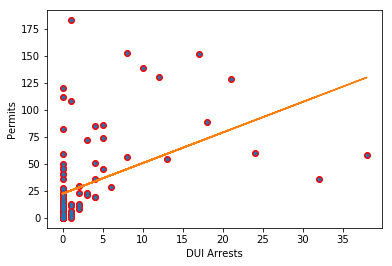

In [76]:
# ARREST v. PERMIT SCATTERPLOT

permit_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        permit_matrix_scatter[i][j] = in_list[2]

PF = np.array(permit_matrix_scatter).flatten()

plt.scatter(AF[:],PF[:], c='red')
# Set our axis values
x = AF
y = PF

# Fit to a line with polyfit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.xlabel('DUI Arrests')
plt.ylabel('Permits')
print("Ratio of Permits per Arrest: ", m)

plt.show()

# 3. OLS Modeling

In [78]:
import patsy
import statsmodels.api as sm

In [79]:
# Regression 1: Permits vs. Arrests
x = PF
y = AF

# Take the arrays uses for crash and arrest data, and create an OLS model.
arrest_permits = pd.DataFrame({'x': x, 'y':y})

# Let Arrests be our dependent value, based on number of Permits.
outcome, predictors = patsy.dmatrices('y ~ x', arrest_permits)

mod = sm.OLS(outcome,predictors)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     24.55
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           3.03e-06
Time:                        11:14:34   Log-Likelihood:                -317.03
No. Observations:                 100   AIC:                             638.1
Df Residuals:                      98   BIC:                             643.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5810      0.724      0.803      0.4

OLS Results: How well do permit counts predict arrest counts?
-------------------
Since our p-value obtained is very small (reads as 0.000) for the x column which represents permit counts, we can say with confidence that our coefficient of 0.0707 is statistically significant and close to the true value of arrests per permit. Thus, we can approximate that there are roughly 7 arrests for every 100 alcohol permits in San Diego.

In [80]:
# Regression 2: Permits vs. Crashes

# Assign x column to 'CF' (Crash data), y column to 'PF' (Permit data)
x = PF
y = CF
# Take the arrays uses for crash and arrest data, and create an OLS model.
crash_permits = pd.DataFrame({'x': x, 'y':y})
outcome, predictors = patsy.dmatrices('y ~ x', crash_permits)

mod = sm.OLS(outcome,predictors)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     18.93
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           3.33e-05
Time:                        11:14:41   Log-Likelihood:                -158.68
No. Observations:                 100   AIC:                             321.4
Df Residuals:                      98   BIC:                             326.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1463      0.148      0.985      0.3

OLS Results: How well do permit counts predict crash counts?
------------------------
Since the results above show a very small p value (reads 0.000 for the y column, represented by Permit Count data, we see that our coefficient is statistically significant and we can believe with confidence that there are roughly 127 car crashes for every 10,000 alcohol permits in San Diego.

In [116]:
# Sort matrix cells by population, create a histogram that shows what the distribution
# of arrests/crashes is. 

from operator import itemgetter
pop_arrests = {}
for i in range(0, len(matrix)-1):
    for j in range(0, len(matrix)-1):
        population = ((matrix[i])[j])[3]
        arrests = ((matrix[i])[j])[1]
        # add key-value pairs of population and arrest to a dictionary.
        pop_arrests[population] = arrests

pop_arrests
#sorted(matrix[1], key=itemgetter(3))

{0: 0,
 283.75: 0,
 858.75: 0,
 1063.25: 0,
 4544.0: 0,
 4547.75: 18,
 5759.75: 0,
 5963.0: 5,
 6585.75: 2,
 7329.5: 1,
 7583.0: 2,
 8581.5: 0,
 8770.5: 1,
 8944.5: 8,
 10845.5: 8,
 11236.75: 3,
 11450.5: 38,
 11848.25: 0,
 12194.0: 4,
 12407.5: 21,
 12429.0: 1,
 12654.25: 32,
 12802.0: 4,
 15689.75: 2,
 16358.25: 4,
 18259.25: 0,
 18259.75: 0,
 18553.25: 12,
 19064.5: 1,
 19808.25: 0,
 21224.75: 5,
 24621.75: 13,
 27137.75: 1,
 28309.25: 6}

In [215]:
import operator
sorted_x = sorted(pop_arrests.items(), key=operator.itemgetter(0))

y = np.zeros(len(sorted_x))
x = np.zeros(len(sorted_x))

for i in range(0, len(sorted_x)):
    y[i] = int(sorted_x[i][1])
    x[i] = int(sorted_x[i][0])
x
y

array([  0.,   0.,   0.,   0.,   0.,  18.,   0.,   5.,   2.,   1.,   2.,
         0.,   1.,   8.,   8.,   3.,  38.,   0.,   4.,  21.,   1.,  32.,
         4.,   2.,   4.,   0.,   0.,  12.,   1.,   0.,   5.,  13.,   1.,
         6.])

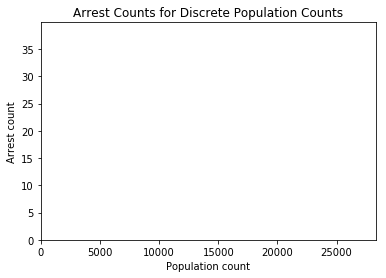

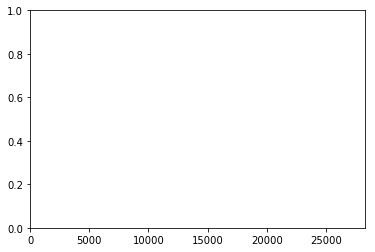

0.0
28309.0


In [220]:
# Plot bar chart
import matplotlib.ticker as ticker
import math
ax = plt.subplot()
#x = range(len(y))
range_thing = range(len(y))
#plt.bar(range(len(pop_arrests)), pop_arrests.values(),align='center', color='g')
plt.bar(range_thing, y, align='center', color='g')
#plt.xticks(range(len(pop_arrests)), pop_arrests.keys())
plt.xlabel('Population count')
plt.ylabel('Arrest count')
plt.title('Arrest Counts for Discrete Population Counts')
plt.show()


low = min(x)
high = max(x)
plt.xlim(low, high)
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.show()
print(low)
print(high)


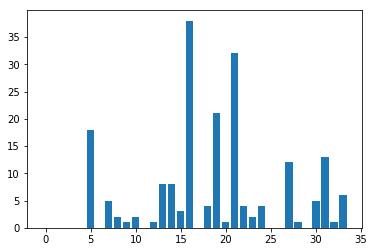

In [247]:

lists = sorted(pop_arrests.items()) # sorted by key, return a list of tuples

x, y = zip(*lists)
x1 = np.array(x)
y1 = np.array(y)
range_x1 = range(len(x1))

plt.bar(range_x1, y1)
plt.show()

# Discussion

# Conclusion